# Imports

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import torch.nn as nn
import torch

In [53]:
from utils import MnistData, Clipper
from models import ModelManager, ModelType
from adversarials import ClassificationAdversarials

In [54]:
import numpy as np
from matplotlib import pyplot as plt

# Settings

In [55]:
linfty_norm_radius = 50 / 255
lone_norm_radius = 28 * 28 * 50 / 255
ltwo_norm_radius = 28 * 50 / 255

In [56]:
model = ModelManager.get_trained(ModelType.MnistCnnB)

In [57]:
batch_size = 100

In [58]:
data = MnistData(True)

In [74]:
c_lambda = 100

# CW functions

In [60]:
def mnist_batch_linfty_norm(input:torch.Tensor) -> torch.Tensor:
    return torch.max(torch.max(torch.max(torch.abs(input), dim=3)[0], dim=2)[0], dim=1)[0]

def mnist_batch_lone_norm(input:torch.Tensor) -> torch.Tensor:
    return (torch.abs(input)).sum(3).sum(2).sum(1)

def mnist_batch_ltwo_norm(input:torch.Tensor) -> torch.Tensor:
    return ((input ** 2).sum(3).sum(2).sum(1)) ** (1 / 2)

In [61]:
def cw_batch_clip_always(model: nn.Module, benign_examples: torch.Tensor, labels: torch.Tensor, norm_radius, c_lambda: float, batch_norm) -> torch.Tensor:
    adversarial_examples = torch.zeros(benign_examples.shape)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    step_size = 1e-2
    for _ in range(100):
        adversarial_examples.requires_grad = True
        if adversarial_examples.grad is not None:
            adversarial_examples.grad.zero_()
        benign_examples.requires_grad = True
        if benign_examples.grad is not None:
            benign_examples.grad.zero_()
        loss = batch_norm(adversarial_examples - benign_examples).sum() - c_lambda * loss_fn(model(adversarial_examples), labels)
        loss.backward()
        adversarial_examples = (adversarial_examples - step_size * adversarial_examples.grad.apply_(lambda x: 1 if x >= 0 else -1)).detach()
        adversarial_examples = Clipper.clip_batch(benign_examples, adversarial_examples, batch_norm, norm_radius)
    # return Clipper.clip_batch(benign_examples, adversarial_examples, batch_norm, norm_radius)
    return adversarial_examples

def cw_batch_clip_once(model: nn.Module, benign_examples: torch.Tensor, labels: torch.Tensor, norm_radius, c_lambda: float, batch_norm) -> torch.Tensor:
    adversarial_examples = torch.zeros(benign_examples.shape)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    step_size = 1e-2
    for _ in range(100):
        adversarial_examples.requires_grad = True
        if adversarial_examples.grad is not None:
            adversarial_examples.grad.zero_()
        benign_examples.requires_grad = True
        if benign_examples.grad is not None:
            benign_examples.grad.zero_()
        loss = batch_norm(adversarial_examples - benign_examples).sum() - c_lambda * loss_fn(model(adversarial_examples), labels)
        loss.backward()
        adversarial_examples = (adversarial_examples - step_size * adversarial_examples.grad.apply_(lambda x: 1 if x >= 0 else -1)).detach()
        # adversarial_examples = Clipper.clip_batch(benign_examples, adversarial_examples, batch_norm, norm_radius)
    return Clipper.clip_batch(benign_examples, adversarial_examples, batch_norm, norm_radius)
    # return adversarial_examples

# Generation

In [62]:
benign_examples, labels = data.choose_first_well_classified(batch_size, model)

In [75]:
cw_linfty_examples_clip_always = cw_batch_clip_always(model, benign_examples, labels, linfty_norm_radius, c_lambda, mnist_batch_linfty_norm)
cw_lone_examples_clip_always = cw_batch_clip_always(model, benign_examples, labels, lone_norm_radius, c_lambda, mnist_batch_lone_norm)
cw_ltwo_examples_clip_always = cw_batch_clip_always(model, benign_examples, labels, ltwo_norm_radius, c_lambda, mnist_batch_ltwo_norm)

cw_linfty_examples_clip_once = cw_batch_clip_once(model, benign_examples, labels, linfty_norm_radius, c_lambda, mnist_batch_linfty_norm)
cw_lone_examples_clip_once = cw_batch_clip_once(model, benign_examples, labels, lone_norm_radius, c_lambda, mnist_batch_lone_norm)
cw_ltwo_examples_clip_once = cw_batch_clip_once(model, benign_examples, labels, ltwo_norm_radius, c_lambda, mnist_batch_ltwo_norm)

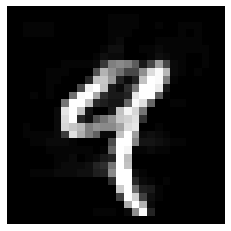

In [76]:
# Save some
for i in [1, 3, 5, 7, 2, 34, 18, 37, 17, 4]:
    example = np.array(benign_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\CW_BATCH\\benign_{i}.png", bbox_inches="tight", pad_inches=0)
    
    example = np.array(cw_linfty_examples_clip_always[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\CW_BATCH\\clip_always_c_lambda_{c_lambda}_cw_linfty_{i}.png", bbox_inches="tight", pad_inches=0)
    
    example = np.array(cw_lone_examples_clip_always[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\CW_BATCH\\clip_always_c_lambda_{c_lambda}_cw_lone_{i}.png", bbox_inches="tight", pad_inches=0)
    
    example = np.array(cw_ltwo_examples_clip_always[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\CW_BATCH\\clip_always_c_lambda_{c_lambda}_cw_ltwo_{i}.png", bbox_inches="tight", pad_inches=0)

    example = np.array(cw_linfty_examples_clip_once[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\CW_BATCH\\clip_once_c_lambda_{c_lambda}_cw_linfty_{i}.png", bbox_inches="tight", pad_inches=0)
    
    example = np.array(cw_lone_examples_clip_once[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\CW_BATCH\\clip_once_c_lambda_{c_lambda}_cw_lone_{i}.png", bbox_inches="tight", pad_inches=0)
    
    example = np.array(cw_ltwo_examples_clip_once[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\CW_BATCH\\clip_once_c_lambda_{c_lambda}_cw_ltwo_{i}.png", bbox_inches="tight", pad_inches=0)


In [77]:

cw_linfty_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, cw_linfty_examples_clip_always)
print(f'cw_linfty_always: {len(cw_linfty_adversarials)}')

cw_lone_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, cw_lone_examples_clip_always)
print(f'cw_lone_always: {len(cw_lone_adversarials)}')

cw_ltwo_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, cw_ltwo_examples_clip_always)
print(f'cw_ltwo_always: {len(cw_ltwo_adversarials)}')

cw_linfty_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, cw_linfty_examples_clip_once)
print(f'cw_linfty_once: {len(cw_linfty_adversarials)}')

cw_lone_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, cw_lone_examples_clip_once)
print(f'cw_lone_once: {len(cw_lone_adversarials)}')

cw_ltwo_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, cw_ltwo_examples_clip_once)
print(f'cw_ltwo_once: {len(cw_ltwo_adversarials)}')

cw_linfty_always: 74
cw_lone_always: 90
cw_ltwo_always: 16
cw_linfty_once: 0
cw_lone_once: 93
cw_ltwo_once: 94
